In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset_final.csv to dataset_final.csv


In [3]:
import pandas as pd

df = pd.read_csv("dataset_final.csv")  # 업로드한 실제 파일명
df.head()

,text,label
0,수사관님이 바뀌셨다고 들었는데 맞나요? 창원지검 형사1부 이정훈 수사관입니다 기...,0
1,전화 받았는데 일정 다시 확인하려고요 대전지검 강력부 박민수 수사관입니다 출석 ...,0
2,가족이 대신 출석 가능한가요? 춘천지검 조사과 이나래 수사관입니다 해당 건은 본...,0
3,검찰청에서 전화가 왔어요 인천지검 범죄수익환수부 정유라 수사관입니다 무슨 건으로...,0
4,대면 출석이 어려운데 전화 조사도 가능할까요? 춘천지검 형사1부 박시은 수사관입니...,0


In [4]:
import torch
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
import re

# 1. 텍스트 전처리 (불필요한 특수문자 제거)
def clean_text(text):
    text = re.sub(r"[^ㄱ-ㅎ가-힣0-9\s.,!?]", "", text)
    return text.strip()

texts = df['text'].astype(str).tolist()
labels = df['label'].values

# 2. 텍스트 정제 + 토큰화
cleaned_texts = [clean_text(t) for t in texts]
tokenized_texts = [t.split() for t in cleaned_texts]

# 3. 단어 사전 생성
word2idx = defaultdict(lambda: 1)  # OOV 토큰
word2idx["<PAD>"] = 0
word2idx["<OOV>"] = 1

idx = 2
for sentence in tokenized_texts:
    for word in sentence:
        if word not in word2idx:
            word2idx[word] = idx
            idx += 1

# 4. 정수 인코딩
encoded_texts = [[word2idx[word] for word in sentence] for sentence in tokenized_texts]

# 5. 패딩 처리
MAX_LEN = 300
tensor_sequences = [torch.tensor(seq[:MAX_LEN], dtype=torch.long) for seq in encoded_texts]
padded_X = pad_sequence(tensor_sequences, batch_first=True, padding_value=0)

# 6. 라벨 변환
tensor_y = torch.tensor(labels, dtype=torch.long)

# 7. 결과 확인
print("✅ 전처리 완료!")
print(f"문장 수: {padded_X.shape[0]}, 문장 길이: {padded_X.shape[1]}")
print(f"라벨 형태: {tensor_y.shape}")
print(f"단어 사전 크기: {len(word2idx)}")

✅ 전처리 완료!
문장 수: 792, 문장 길이: 300
라벨 형태: torch.Size([792])
단어 사전 크기: 53228


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# 1. 학습/검증 데이터 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(padded_X, tensor_y, test_size=0.2, random_state=42)

# 2. PyTorch Dataset 클래스 정의
class TalkDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)# 1. 나눔고딕 설치
!apt-get -qq install -y fonts-nanum

# 2. 런타임 재시작 후 아래 코드 실행
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 3. 설치된 나눔고딕 경로 확인 및 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 4. 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# 5. 테스트 그래프
plt.figure()
plt.plot([1, 2, 3], [1, 4, 9])
plt.title('한글 그래프 테스트')
plt.xlabel('가로축')
plt.ylabel('세로축')
plt.show()

test_dataset = TalkDataset(X_test, y_test)

# 4. DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print("✅ DataLoader 생성 완료! 학습 준비 끝!")

✅ DataLoader 생성 완료! 학습 준비 끝!


In [6]:
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)
        output, hidden = self.gru(embedded)  # hidden: (1, batch, hidden_dim)
        return self.fc(hidden[-1])  # 마지막 hidden 상태만 사용


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GRUClassifier(
    vocab_size=len(word2idx),
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,  # 이진 분류 (0, 1)
    padding_idx=word2idx["<PAD>"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"✅ 모델 준비 완료 (device: {device})")

✅ 모델 준비 완료 (device: cuda)


In [8]:
# 학습 루프
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"🟢 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f}")

🟢 Epoch 1/5 | Loss: 13.2712
🟢 Epoch 2/5 | Loss: 10.8796
🟢 Epoch 3/5 | Loss: 9.2832
🟢 Epoch 4/5 | Loss: 9.2425
🟢 Epoch 5/5 | Loss: 8.2223


In [9]:
# 평가
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        predicted = torch.argmax(preds, dim=1)# 1. 나눔고딕 설치
!apt-get -qq install -y fonts-nanum

# 2. 런타임 재시작 후 아래 코드 실행
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 3. 설치된 나눔고딕 경로 확인 및 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 4. 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# 5. 테스트 그래프
plt.figure()
plt.plot([1, 2, 3], [1, 4, 9])
plt.title('한글 그래프 테스트')
plt.xlabel('가로축')
plt.ylabel('세로축')
plt.show()

print(f"\n✅ 테스트 정확도: {accuracy:.4f}")




✅ 테스트 정확도: 0.7799


In [10]:
import torch.nn as nn

# ✅ Bi-GRU 분류기 정의
class BiGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # 양방향이므로 2배

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        # hidden shape: (2, batch, hidden_dim) → 양방향이므로 2개
        # hidden[-2,:,:] = forward, hidden[-1,:,:] = backward
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)  # (batch, hidden_dim*2)
        return self.fc(hidden_cat)


In [11]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 생성
model = BiGRUClassifier(
    vocab_size=len(word2idx),
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    padding_idx=word2idx["<PAD>"]
).to(device)

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"✅ Bi-GRU 모델 준비 완료 (device: {device})")

✅ Bi-GRU 모델 준비 완료 (device: cuda)


In [12]:
# 학습 루프
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"🟢 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f}")

🟢 Epoch 1/5 | Loss: 12.2276
🟢 Epoch 2/5 | Loss: 8.0219
🟢 Epoch 3/5 | Loss: 4.3126
🟢 Epoch 4/5 | Loss: 1.6908
🟢 Epoch 5/5 | Loss: 0.6884


In [13]:
# 평가
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        predicted = torch.argmax(preds, dim=1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = correct / total
print(f"\n✅ 테스트 정확도: {accuracy:.4f}")


✅ 테스트 정확도: 0.9245


In [14]:
class StackedGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.gru = nn.GRU(
            embedding_dim, hidden_dim,
            num_layers=2,             # ← 층 2개!
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        return self.fc(hidden[-1])  # 마지막 층의 hidden만 사용


In [15]:
model = StackedGRUClassifier(
    vocab_size=len(word2idx),
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    padding_idx=word2idx["<PAD>"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("✅ Stacked GRU 준비 완료")


✅ Stacked GRU 준비 완료


In [16]:
# 학습 루프
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"🟢 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f}")

🟢 Epoch 1/5 | Loss: 12.7206
🟢 Epoch 2/5 | Loss: 9.1819
🟢 Epoch 3/5 | Loss: 9.7339
🟢 Epoch 4/5 | Loss: 7.8657
🟢 Epoch 5/5 | Loss: 7.1337


In [17]:
# 평가
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        predicted = torch.argmax(preds, dim=1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = correct / total
print(f"\n✅ 테스트 정확도: {accuracy:.4f}")


✅ 테스트 정확도: 0.8050


In [18]:
class StackedGRUWithDropout(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=2,
            dropout=0.3,          # ✅ Dropout 추가!
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        return self.fc(hidden[-1])

In [19]:
model = StackedGRUWithDropout(
    vocab_size=len(word2idx),
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    padding_idx=word2idx["<PAD>"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("✅ Dropout GRU 준비 완료")

✅ Dropout GRU 준비 완료


In [20]:
# 학습 루프
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"🟢 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f}")

🟢 Epoch 1/5 | Loss: 12.9626
🟢 Epoch 2/5 | Loss: 9.7716
🟢 Epoch 3/5 | Loss: 8.8441
🟢 Epoch 4/5 | Loss: 7.5597
🟢 Epoch 5/5 | Loss: 8.3545


In [21]:
# 평가
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        predicted = torch.argmax(preds, dim=1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = correct / total
print(f"\n✅ 테스트 정확도: {accuracy:.4f}")


✅ 테스트 정확도: 0.7799


In [22]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, gru_output):
        # gru_output: (batch_size, seq_len, hidden_dim)
        attn_weights = torch.softmax(self.attn(gru_output), dim=1)  # (batch, seq_len, 1)
        context = torch.sum(attn_weights * gru_output, dim=1)       # (batch, hidden_dim)
        return context

In [23]:
class AttentionGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)                     # (batch, seq_len, embed_dim)
        output, hidden = self.gru(embedded)              # output: (batch, seq_len, hidden_dim)
        context = self.attention(output)                 # context: (batch, hidden_dim)
        return self.fc(context)


In [24]:
model = AttentionGRUClassifier(
    vocab_size=len(word2idx),
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    padding_idx=word2idx["<PAD>"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("✅ Attention-GRU 준비 완료")


✅ Attention-GRU 준비 완료


In [25]:
# 학습 루프
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"🟢 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f}")

🟢 Epoch 1/5 | Loss: 12.4857
🟢 Epoch 2/5 | Loss: 7.4521
🟢 Epoch 3/5 | Loss: 3.1520
🟢 Epoch 4/5 | Loss: 1.7861
🟢 Epoch 5/5 | Loss: 0.9836


In [26]:
# 평가
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        predicted = torch.argmax(preds, dim=1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = correct / total
print(f"\n✅ 테스트 정확도: {accuracy:.4f}")


✅ 테스트 정확도: 0.9623


In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


✅ 테스트 정확도: 0.9623


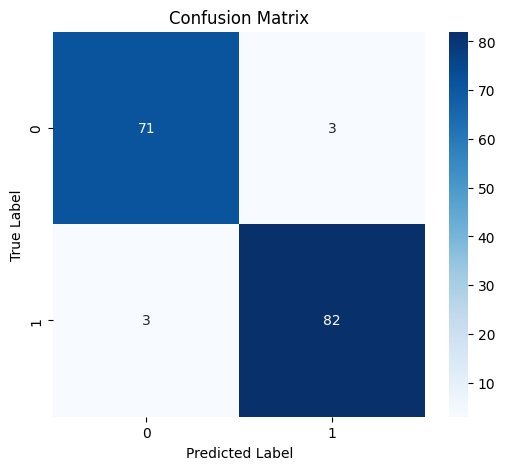


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9595    0.9595    0.9595        74
           1     0.9647    0.9647    0.9647        85

    accuracy                         0.9623       159
   macro avg     0.9621    0.9621    0.9621       159
weighted avg     0.9623    0.9623    0.9623       159



In [29]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        predicted = torch.argmax(outputs, dim=1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# ① 정확도
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n✅ 테스트 정확도: {accuracy:.4f}")

# ② Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ③ Precision / Recall / F1-score
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))


In [40]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'  # or 'Malgun Gothic' (Windows) / 'AppleGothic' (Mac)
plt.rc("font", family="NanumGothic")
plt.rc("axes", unicode_minus=False)

100%|██████████| 5/5 [03:36<00:00, 43.39s/it]
/tmp/ipython-input-2337406692.py:39: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2337406692.py:39: UserWarning: Glyph 53469 (\N{HANGUL SYLLABLE TAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2337406692.py:39: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2337406692.py:39: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2337406692.py:39: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2337406692.py:39: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2337406692.py:39: UserWarning: Glyph 47140 (\N{HANGUL SYLLABLE RYEO}) missing f

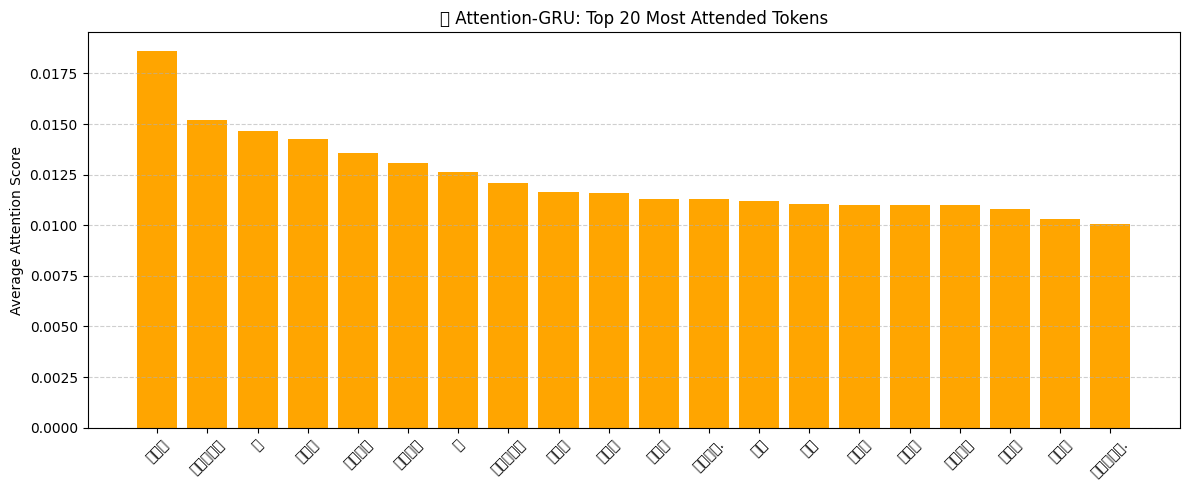

In [41]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm

# 단어별 attention 누적 dict
token_weights = defaultdict(list)

model.eval()
with torch.no_grad():
    for X_batch, y_batch in tqdm(test_loader):
        X_batch = X_batch.to(device)

        embedded = model.embedding(X_batch)                      # (batch, seq_len, embed)
        output, hidden = model.gru(embedded)                     # (batch, seq_len, hidden)
        attn_scores = torch.softmax(model.attention.attn(output), dim=1)  # (batch, seq_len, 1)
        attn_scores = attn_scores.squeeze(-1).cpu().numpy()     # (batch, seq_len)

        X_batch_cpu = X_batch.cpu().numpy()
        for sentence, scores in zip(X_batch_cpu, attn_scores):
            for token_id, score in zip(sentence, scores):
                if token_id == word2idx["<PAD>"]:
                    continue
                word = [k for k, v in word2idx.items() if v == token_id][0]
                token_weights[word].append(score)

# 단어별 평균 attention score 계산
avg_weights = {word: np.mean(scores) for word, scores in token_weights.items()}
sorted_weights = sorted(avg_weights.items(), key=lambda x: x[1], reverse=True)

# 상위 20개 단어 출력 및 시각화
top_words = sorted_weights[:20]
words, scores = zip(*top_words)

plt.figure(figsize=(12, 5))
plt.bar(words, scores, color='orange')
plt.title("📌 Attention-GRU: Top 20 Most Attended Tokens")
plt.ylabel("Average Attention Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [31]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'  # or 'Malgun Gothic' (Windows) / 'AppleGothic' (Mac)
plt.rc("font", family="NanumGothic")
plt.rc("axes", unicode_minus=False)

# 또는 Colab이라면 아래처럼 설치하고 적용
!apt-get -qq install fonts-nanum
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')


Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [35]:
!apt-get -qq install -y fonts-nanum

In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 정확한 경로에 있는 ttf 파일로 폰트 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)
print(fontprop.get_name())  # 폰트 이름 확인용

NanumGothic


In [37]:
# 폰트 이름을 직접 rc에 등록
mpl.rcParams['font.family'] = fontprop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


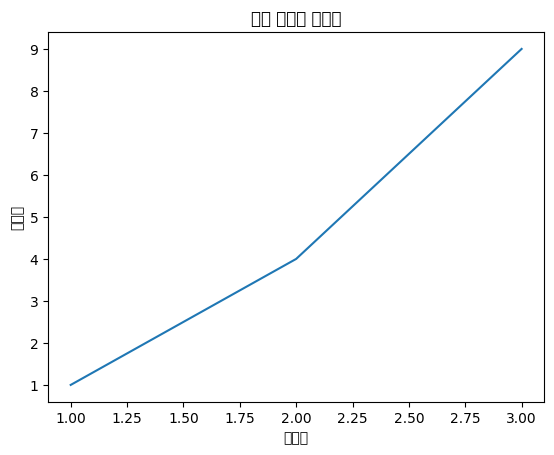

In [38]:
plt.figure()
plt.plot([1, 2, 3], [1, 4, 9])
plt.title('한글 그래프 테스트')
plt.xlabel('가로축')
plt.ylabel('세로축')
plt.show()

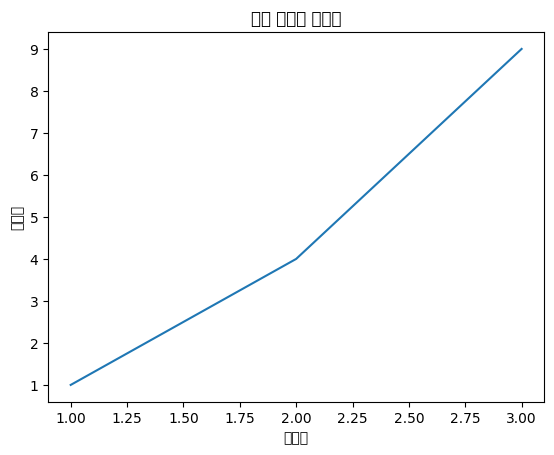

In [39]:
# 1. 나눔고딕 설치
!apt-get -qq install -y fonts-nanum

# 2. 런타임 재시작 후 아래 코드 실행
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 3. 설치된 나눔고딕 경로 확인 및 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 4. 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# 5. 테스트 그래프
plt.figure()
plt.plot([1, 2, 3], [1, 4, 9])
plt.title('한글 그래프 테스트')
plt.xlabel('가로축')
plt.ylabel('세로축')
plt.show()
